In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle

print("done")

done


In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

## 数据集的加载

In [3]:
train_data = []
train_labels = []

for i in range(1,6):
    file_name = f"autodl-tmp/cifar-10-batches-py/data_batch_{i}"
    batch = unpickle(file_name)
    train_labels.extend(batch[b'labels'])
    train_data.append(batch[b'data'])
    
# 将列表转换为 NumPy 数组
train_data = np.vstack(train_data)  # 将所有批次数据垂直拼接
train_labels = np.array(train_labels)  # 转换为 NumPy 数组
    
print(f'Data shape: {train_data.shape}')  # (50000, 3072)
print(f'Number of labels: {len(train_labels)}')  # 50000
print(f'Example labels: {train_labels[:10]}')

Data shape: (50000, 3072)
Number of labels: 50000
Example labels: [6 9 9 4 1 1 2 7 8 3]


## 测试集的加载

In [4]:
test_data = []
test_labels = []

file_name = "autodl-tmp/cifar-10-batches-py/test_batch"
batch = unpickle(file_name)
test_labels = batch[b'labels']
test_data = batch[b'data']

print(f'test shape: {test_data.shape}')  # (10000, 3072)
print(f'Number of test labels: {len(test_labels)}')  # 10000
print(f'Example labels: {train_labels[:10]}')

test shape: (10000, 3072)
Number of test labels: 10000
Example labels: [6 9 9 4 1 1 2 7 8 3]


## 类型名称 

In [5]:
meta_data = unpickle('autodl-tmp/cifar-10-batches-py/batches.meta')
# 打印 meta 文件中的键和值
# print(f'Meta keys: {meta_data.keys()}')

# 获取标签名称
label_names = meta_data[b'label_names']

# 打印所有类别标签名称
print('Label names:')
for i, name in enumerate(label_names):
    print(f'{i}: {name.decode("utf-8")}')

Label names:
0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


In [6]:
print(batch.keys())

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


## 数据的处理和展示

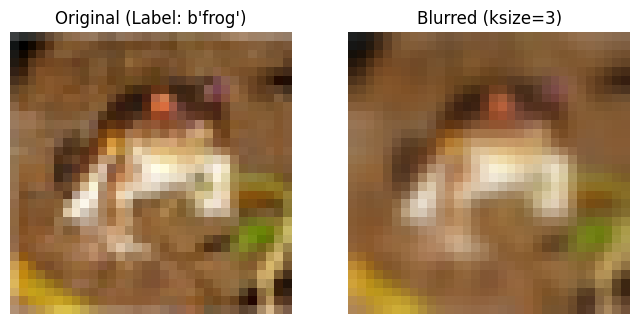

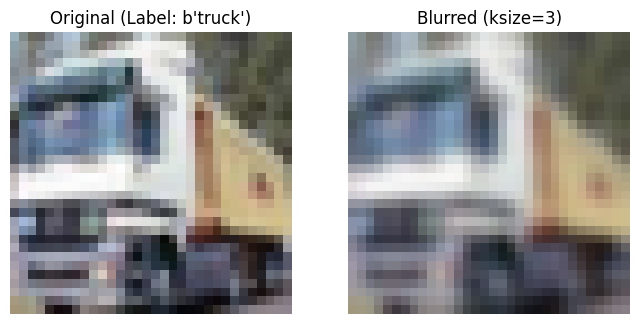

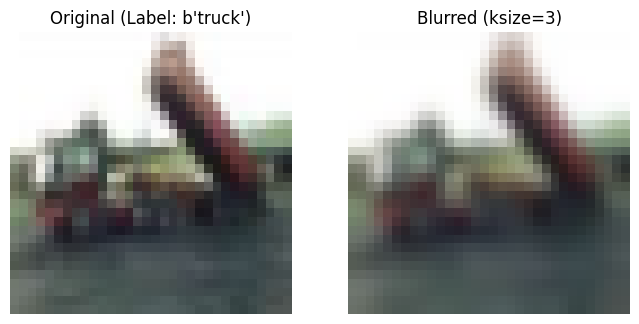

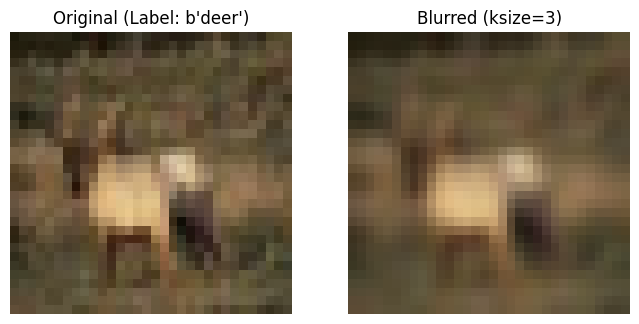

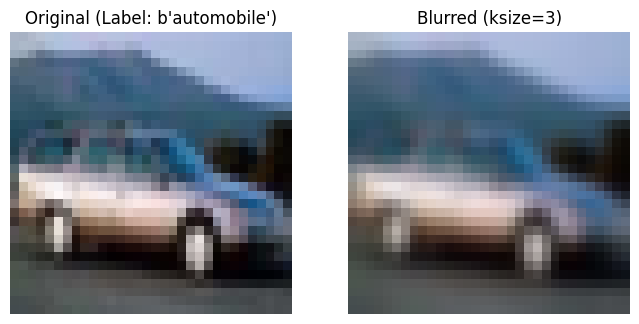

In [12]:
import cv2
import matplotlib.pyplot as plt

def apply_gaus_blur(image, blur_ksize=3):
    """应用高斯模糊"""
    return cv2.GaussianBlur(image, (blur_ksize, blur_ksize), 0)

def show_image_comparison(image_data, label, blur_ksize=3):
    """展示原图和模糊后的图片对比"""
    # 将 (3072,) 转换为 (32, 32, 3)
    img = image_data.reshape(3, 32, 32).transpose(1, 2, 0)
    
    # 应用高斯模糊
    blurred_img = apply_gaus_blur(img, blur_ksize)

    # 创建子图：1行2列，第1张展示原图，第2张展示模糊图
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # 展示原图
    axes[0].imshow(img)
    axes[0].set_title(f'Original (Label: {label_names[label]})')
    axes[0].axis('off')

    # 展示模糊图
    axes[1].imshow(blurred_img)
    axes[1].set_title(f'Blurred (ksize={blur_ksize})')
    axes[1].axis('off')

    plt.savefig(f'pic/{label_names[label]}.jpg')
    plt.show()
    

# 显示前 5 张图片的原图与模糊后的对比
for i in range(5):
    show_image_comparison(train_data[i], train_labels[i])

## ResNet-26分类CIFAR10

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import os

## 模型建立

In [12]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet26(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet26, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(64, 64, 4, stride=1)
        self.layer2 = self._make_layer(64, 128, 4, stride=2)
        self.layer3 = self._make_layer(128, 256, 4, stride=2)
        self.layer4 = self._make_layer(256, 512, 4, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


## 数据加载器

In [13]:
def load_data(root='autodl-tmp/cifar-10-batches-py'):
    """加载并预处理CIFAR-10训练集和测试集"""
    # 初始化训练集
    train_data = []
    train_labels = []

    # 加载5个训练批次
    for i in range(1, 6):
        batch = unpickle(f"{root}/data_batch_{i}")
        train_data.append(batch[b'data'])
        train_labels.extend(batch[b'labels'])

    # 转换为NumPy数组
    train_data = np.vstack(train_data).reshape(-1, 3, 32, 32)  # (50000, 3, 32, 32)
    train_labels = np.array(train_labels)

    # 加载测试集
    test_batch = unpickle(f"{root}/test_batch")
    test_data = test_batch[b'data'].reshape(-1, 3, 32, 32)  # (10000, 3, 32, 32)
    test_labels = np.array(test_batch[b'labels'])

    # 转换为 PyTorch 张量
    train_data = torch.tensor(train_data, dtype=torch.float32) / 255.0
    train_labels = torch.tensor(train_labels, dtype=torch.long)
    test_data = torch.tensor(test_data, dtype=torch.float32) / 255.0
    test_labels = torch.tensor(test_labels, dtype=torch.long)

    return (train_data, train_labels), (test_data, test_labels)

def create_dataloaders(batch_size=128, root='autodl-tmp/cifar-10-batches-py'):
    """创建训练和测试数据加载器"""
    # 加载数据
    (train_data, train_labels), (test_data, test_labels) = load_data(root)

    # 封装为 TensorDataset
    train_dataset = TensorDataset(train_data, train_labels)
    test_dataset = TensorDataset(test_data, test_labels)

    # 数据集拆分：训练集和验证集 (80% 训练, 20% 验证)
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    # 创建 DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# 使用示例
train_loader, val_loader, test_loader = create_dataloaders(batch_size=128)

# 打印数据的大小
for images, labels in train_loader:
    print(f'Image batch shape: {images.shape}')  # e.g., (128, 3, 32, 32)
    print(f'Label batch shape: {labels.shape}')  # e.g., (128,)
    break

Image batch shape: torch.Size([128, 3, 32, 32])
Label batch shape: torch.Size([128])


## 模型训练和评估

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet26(num_classes=10).to(device)

# 创建目录保存权重文件
os.makedirs('checkpoints', exist_ok=True)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# 学习率调整策略
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# 创建目录保存权重文件和表格数据
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('logs', exist_ok=True)

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs):
    """训练和验证模型，并保存损失和准确率变化到 CSV 文件"""
    history = {'epoch': [], 'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        # 训练循环
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total

        # 验证循环
        val_loss, val_acc = evaluate(model, val_loader, criterion)

        # 记录每个 epoch 的结果
        history['epoch'].append(epoch + 1)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        # 打印每个 epoch 的结果
        print(f'Epoch [{epoch+1}/{epochs}] | '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        # 学习率调整
        scheduler.step()
        
    # 保存权重文件
    torch.save(model.state_dict(), f'checkpoints/resnet26.pth')

    # 保存损失和准确率到 CSV 文件
    df = pd.DataFrame(history)
    df.to_csv('logs/training_log.csv', index=False)
    print("训练日志已保存至 logs/training_log.csv")

def evaluate(model, dataloader, criterion):
    """评估模型在验证集上的性能"""
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = running_loss / len(dataloader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

In [17]:
epoch_size = 100
# 开始训练，并记录损失和准确率
train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=epoch_size)

Epoch [1/100] | Train Loss: 2.4012, Train Acc: 19.16% | Val Loss: 1.8842, Val Acc: 27.48%
Epoch [2/100] | Train Loss: 1.7242, Train Acc: 35.50% | Val Loss: 1.6736, Val Acc: 37.86%
Epoch [3/100] | Train Loss: 1.5153, Train Acc: 44.07% | Val Loss: 1.7568, Val Acc: 39.81%
Epoch [4/100] | Train Loss: 1.3236, Train Acc: 51.47% | Val Loss: 1.3362, Val Acc: 51.19%
Epoch [5/100] | Train Loss: 1.1198, Train Acc: 59.45% | Val Loss: 1.1263, Val Acc: 59.46%
Epoch [6/100] | Train Loss: 0.9620, Train Acc: 65.87% | Val Loss: 1.0325, Val Acc: 64.00%
Epoch [7/100] | Train Loss: 0.8372, Train Acc: 70.31% | Val Loss: 1.0551, Val Acc: 64.24%
Epoch [8/100] | Train Loss: 0.7427, Train Acc: 73.83% | Val Loss: 1.1037, Val Acc: 62.95%
Epoch [9/100] | Train Loss: 0.6373, Train Acc: 77.82% | Val Loss: 0.9331, Val Acc: 67.63%
Epoch [10/100] | Train Loss: 0.5456, Train Acc: 81.08% | Val Loss: 0.8657, Val Acc: 71.08%
Epoch [11/100] | Train Loss: 0.4821, Train Acc: 83.25% | Val Loss: 0.8202, Val Acc: 73.25%
Epoch [1

## Test数据集的处理

In [18]:
def save_data(file_name, data):
    """保存数据到 pickle 文件"""
    with open(file_name, 'wb') as f:
        pickle.dump(data, f)

def apply_blur_and_shift(image, shift=(2, 2), blur_ksize=3):
    """
    对图像应用高斯模糊和偏移变换。
    shift: (x_shift, y_shift) 偏移像素
    blur_ksize: 高斯模糊核大小
    """
    # 应用高斯模糊
    blurred = cv2.GaussianBlur(image, (blur_ksize, blur_ksize), 0)

    # 构造平移矩阵
    M = np.float32([[1, 0, shift[0]], [0, 1, shift[1]]])
    shifted = cv2.warpAffine(blurred, M, (32, 32))

    return shifted

In [20]:
# 读取原始测试数据
test_batch = unpickle('autodl-tmp/cifar-10-batches-py/test_batch')

# 拆分数据和标签
test_data = test_batch[b'data']
test_labels = test_batch[b'labels']

# 转换形状为 (10000, 32, 32, 3)
test_data = test_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

# 计算原始数据和变换数据的数量
total_samples = len(test_data)
num_raw_samples = int(total_samples * 0.7)  # 70% 原始数据
num_c_samples = total_samples - num_raw_samples  # 20% 变换数据

# 随机选择原始数据的索引
np.random.seed(42)  # 设置随机种子以确保可重复性
raw_indices = np.random.choice(total_samples, num_raw_samples, replace=False)

# 保存原始数据
test_raw_data = test_data[raw_indices]
test_raw_labels = [test_labels[i] for i in raw_indices]

# 保存变换数据
test_c_data = []
test_c_labels = []

for i in range(total_samples):
    if i not in raw_indices:
        # 对剩余的样本应用模糊和偏移
        transformed_img = apply_blur_and_shift(test_data[i], shift=(3, 3), blur_ksize=5)
        test_c_data.append(transformed_img)
        test_c_labels.append(test_labels[i])

# 转换回 CIFAR-10 数据格式 (N, 3, 32, 32)
test_raw_data = np.array(test_raw_data).transpose(0, 3, 1, 2).reshape(-1, 3072)
test_c_data = np.array(test_c_data).transpose(0, 3, 1, 2).reshape(-1, 3072)

# 创建新的数据批次字典
test_raw_batch = {b'data': test_raw_data, b'labels': test_raw_labels}
test_c_batch = {b'data': test_c_data, b'labels': test_c_labels}

# 保存为 pickle 文件
save_data('autodl-tmp/cifar-10-batches-py/test_raw_batch.pkl', test_raw_batch)
save_data('autodl-tmp/cifar-10-batches-py/test_c_batch.pkl', test_c_batch)

print("test_raw 和 test_c 数据已成功保存。")

test_raw 和 test_c 数据已成功保存。


In [24]:
print(test_raw_data.shape)

(7000, 3072)
